In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
pd.set_option("display.max_columns", 200)
import warnings
warnings.filterwarnings('ignore')

d:\Softwares\anaconda3\envs\projeto-santander\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
dados = pd.read_csv("train.csv")
dados_predict = pd.read_csv("test.csv")

In [3]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   object 
 1   account_length                 4250 non-null   int64  
 2   area_code                      4250 non-null   object 
 3   international_plan             4250 non-null   object 
 4   voice_mail_plan                4250 non-null   object 
 5   number_vmail_messages          4250 non-null   int64  
 6   total_day_minutes              4250 non-null   float64
 7   total_day_calls                4250 non-null   int64  
 8   total_day_charge               4250 non-null   float64
 9   total_eve_minutes              4250 non-null   float64
 10  total_eve_calls                4250 non-null   int64  
 11  total_eve_charge               4250 non-null   float64
 12  total_night_minutes            4250 non-null   f

In [4]:
dados.describe()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
count,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000
mean,100.236235,7.631765,180.259600,99.907294,30.644682,200.173906,100.176471,17.015012,200.527882,99.839529,9.023892,10.256071,4.426353,2.769654,1.559059
std,39.698401,13.439882,54.012373,19.850817,9.182096,50.249518,19.908591,4.271212,50.353548,20.093220,2.265922,2.760102,2.463069,0.745204,1.311434
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,73.000000,0.000000,143.325000,87.000000,24.365000,165.925000,87.000000,14.102500,167.225000,86.000000,7.522500,8.500000,3.000000,2.300000,1.000000
50%,100.000000,0.000000,180.450000,100.000000,30.680000,200.700000,100.000000,17.060000,200.450000,100.000000,9.020000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,16.000000,216.200000,113.000000,36.750000,233.775000,114.000000,19.867500,234.700000,113.000000,10.560000,12.000000,6.000000,3.240000,2.000000
max,243.000000,52.000000,351.500000,165.000000,59.760000,359.300000,170.000000,30.540000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [5]:
dados.describe(include="O")

,state,area_code,international_plan,voice_mail_plan,churn
count,4250,4250,4250,4250,4250
unique,51,3,2,2,2
top,WV,area_code_415,no,no,no
freq,139,2108,3854,3138,3652


In [9]:
dados.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,total_net_minutes,total_net_calls,total_net_charge
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no,611.5,329,55.54
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no,527.2,328,59.00
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no,558.2,248,65.02
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no,501.9,356,49.36
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no,779.3,314,76.28


In [7]:
# Criando 3 novas colunas:
# 'total_net_minutes': Soma total dos minutos (dia, tarde, noite),
# 'total_net_calls': Soma do número total de chamadas (dia, tarde, noite),
# 'total_net_charge': Soma total da cobrança das chamadas (dia, tarde, noite)

# Treino
dados['total_net_minutes'] = dados['total_day_minutes'] + dados['total_eve_minutes'] + dados['total_night_minutes']
dados['total_net_calls'] = dados['total_day_calls'] + dados['total_eve_calls'] + dados['total_night_calls']
dados['total_net_charge'] = dados['total_day_charge'] + dados['total_eve_charge'] + dados['total_night_charge']

# Predict
dados_predict['total_net_minutes'] = dados_predict['total_day_minutes'] + dados_predict['total_eve_minutes'] + dados_predict['total_night_minutes']
dados_predict['total_net_calls'] = dados_predict['total_day_calls'] + dados_predict['total_eve_calls'] + dados_predict['total_night_calls']
dados_predict['total_net_charge'] = dados_predict['total_day_charge'] + dados_predict['total_eve_charge'] + dados_predict['total_night_charge']

In [8]:
dados_predict.head()

,id,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,total_net_minutes,total_net_calls,total_net_charge
0,1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,707.2,300,72.86
1,2,AL,118,area_code_510,yes,no,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0,647.9,317,65.91
2,3,IA,62,area_code_415,no,no,0,120.7,70,20.52,307.2,76,26.11,203.0,99,9.14,13.1,6,3.54,4,630.9,245,55.77
3,4,VT,93,area_code_510,no,no,0,190.7,114,32.42,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3,538.5,346,56.80
4,5,NE,174,area_code_415,no,no,0,124.3,76,21.13,277.1,112,23.55,250.7,115,11.28,15.5,5,4.19,3,652.1,303,55.96


In [10]:
# Codificando a variável categórica state

encoder = OrdinalEncoder()
dados["state"] = encoder.fit_transform(dados[["state"]])
dados_predict["state"] = encoder.transform(dados_predict[["state"]])

In [ ]:
# Remove a variável state
# dados.drop("state", axis=1, inplace=True)
# dados_predict.drop("state", axis=1, inplace=True)

In [11]:
# Codificando as variáveis area_code, international_plan, voice_mail_plan e churn

# Train
dados['area_code'] = dados['area_code'].apply(lambda x: int(x.split("_")[2]))
dados['international_plan'] = dados['international_plan'].map(dict(yes=1, no=0))
dados['voice_mail_plan'] = dados['voice_mail_plan'].map(dict(yes=1, no=0))
dados['churn'] = dados['churn'].map(dict(yes=1, no=0))

# Predict
dados_predict['area_code'] = dados_predict['area_code'].apply(lambda x: int(x.split("_")[2]))
dados_predict['international_plan'] = dados_predict['international_plan'].map(dict(yes=1, no=0))
dados_predict['voice_mail_plan'] = dados_predict['voice_mail_plan'].map(dict(yes=1, no=0))
dados_predict.head()

,id,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,total_net_minutes,total_net_calls,total_net_charge
0,1,16.0,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,707.2,300,72.86
1,2,1.0,118,510,1,0,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0,647.9,317,65.91
2,3,12.0,62,415,0,0,0,120.7,70,20.52,307.2,76,26.11,203.0,99,9.14,13.1,6,3.54,4,630.9,245,55.77
3,4,46.0,93,510,0,0,0,190.7,114,32.42,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3,538.5,346,56.80
4,5,29.0,174,415,0,0,0,124.3,76,21.13,277.1,112,23.55,250.7,115,11.28,15.5,5,4.19,3,652.1,303,55.96


In [12]:
dados.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,total_net_minutes,total_net_calls,total_net_charge
0,35.0,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0,611.5,329,55.54
1,31.0,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,527.2,328,59.00
2,35.0,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0,558.2,248,65.02
3,36.0,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0,501.9,356,49.36
4,19.0,121,510,0,1,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,0,779.3,314,76.28


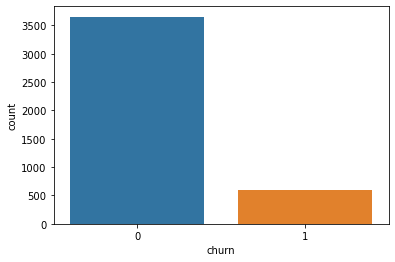

In [13]:
# Variável Target
sns.countplot(x = "churn", data = dados)
plt.show()

In [14]:
# Divisão das variáveis preditoras (X) e da variável target (y)
X = dados.drop("churn", axis=1)
y = dados["churn"]

In [15]:
# Divisão dos dados em Treino e Teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.20, random_state=42)

In [17]:
# Realizando o balanceamento da classe target
print('Antes do balanceamento para o label 0 {}'.format(sum(y_treino==0)))
print('Antes do balanceamento para o label 1 {}'.format(sum(y_treino==1)))

# OverSampling
overSampler = RandomOverSampler(random_state=1)
X_treinoOVR, y_treinoOVR = overSampler.fit_resample(X_treino, y_treino)

print('Depois do balanceamento para o label 0 {}'.format(sum(y_treinoOVR==0)))
print('Depois do balanceamento para o label 1 {}'.format(sum(y_treinoOVR==1)))

Antes do balanceamento para o label 0 2931
Antes do balanceamento para o label 1 469
Depois do balanceamento para o label 0 2931
Depois do balanceamento para o label 1 2931


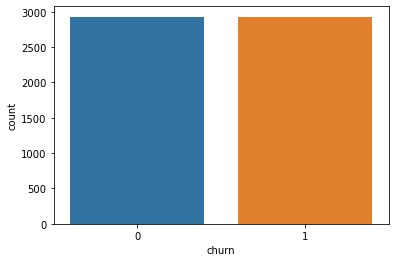

In [18]:
# Gráfico
sns.countplot(x = y_treinoOVR, data = dados)
plt.show()

In [19]:
# Alterando a scala dos dados
std = StandardScaler()
cols = X_treino.columns

# Train
x_std = std.fit_transform(X_treinoOVR)
x_std = pd.DataFrame(x_std, columns=cols)

# Predict
x_teste_std = std.transform(X_teste)

In [21]:
svc = SVC(kernel='rbf', decision_function_shape='ovr')
svc.fit(x_std, y_treinoOVR)
y_pred = svc.predict(x_teste_std)
print(f"Accuracy: {accuracy_score(y_teste, y_pred)}")
print("Classification report: ")
print(f"{classification_report(y_teste, y_pred)}")
print(f"Confusion Matrix")
print(f"{confusion_matrix(y_teste, y_pred)}")
print(f"Cohen kappa score: {cohen_kappa_score(y_teste, y_pred)}")

Accuracy: 0.9094117647058824
Classification report: 
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       721
           1       0.67      0.78      0.72       129

    accuracy                           0.91       850
   macro avg       0.82      0.86      0.83       850
weighted avg       0.92      0.91      0.91       850

Confusion Matrix
[[672  49]
 [ 28 101]]
Cohen kappa score: 0.6701940035273368


In [22]:
rfc = RandomForestClassifier()
rfc.fit(x_std, y_treinoOVR)
y_pred = rfc.predict(x_teste_std)
print(f"Accuracy: {accuracy_score(y_teste, y_pred)}")
print("Classification report: ")
print(f"{classification_report(y_teste, y_pred)}")
print(f"Confusion Matrix")
print(f"{confusion_matrix(y_teste, y_pred)}")
print(f"Cohen kappa score: {cohen_kappa_score(y_teste, y_pred)}")

Accuracy: 0.971764705882353
Classification report: 
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       721
           1       0.96      0.85      0.90       129

    accuracy                           0.97       850
   macro avg       0.97      0.92      0.94       850
weighted avg       0.97      0.97      0.97       850

Confusion Matrix
[[716   5]
 [ 19 110]]
Cohen kappa score: 0.8852191526472739


In [23]:
lr = LogisticRegression()
lr.fit(x_std, y_treinoOVR)
y_pred = lr.predict(x_teste_std)
print(f"Accuracy: {accuracy_score(y_teste, y_pred)}")
print("Classification report: ")
print(f"{classification_report(y_teste, y_pred)}")
print(f"Confusion Matrix")
print(f"{confusion_matrix(y_teste, y_pred)}")
print(f"Cohen kappa score: {cohen_kappa_score(y_teste, y_pred)}")

Accuracy: 0.7788235294117647
Classification report: 
              precision    recall  f1-score   support

           0       0.95      0.78      0.86       721
           1       0.39      0.77      0.51       129

    accuracy                           0.78       850
   macro avg       0.67      0.77      0.68       850
weighted avg       0.86      0.78      0.80       850

Confusion Matrix
[[563 158]
 [ 30  99]]
Cohen kappa score: 0.3895964002230762


In [24]:
xgb = XGBClassifier()
xgb.fit(x_std, y_treinoOVR)
y_pred = xgb.predict(x_teste_std)
print(f"Accuracy: {accuracy_score(y_teste, y_pred)}")
print("Classification report: ")
print(f"{classification_report(y_teste, y_pred)}")
print(f"Confusion Matrix")
print(f"{confusion_matrix(y_teste, y_pred)}")
print(f"Cohen kappa score: {cohen_kappa_score(y_teste, y_pred)}")

[16:24:11] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.9729411764705882
Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       721
           1       0.96      0.86      0.91       129

    accuracy                           0.97       850
   macro avg       0.97      0.93      0.95       850
weighted avg       0.97      0.97      0.97       850

Confusion Matrix
[[716   5]
 [ 18 111]]
Cohen kappa score: 0.8903668644362446


In [25]:
lgbm = LGBMClassifier(random_state=1, n_jobs=-1)
lgbm.fit(x_std, y_treinoOVR)
y_pred = lgbm.predict(x_teste_std)
print(f"Accuracy: {accuracy_score(y_teste, y_pred)}")
print("Classification report: ")
print(f"{classification_report(y_teste, y_pred)}")
print(f"Confusion Matrix")
print(f"{confusion_matrix(y_teste, y_pred)}")
print(f"Cohen kappa score: {cohen_kappa_score(y_teste, y_pred)}")

Accuracy: 0.9764705882352941
Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       721
           1       0.97      0.88      0.92       129

    accuracy                           0.98       850
   macro avg       0.97      0.94      0.95       850
weighted avg       0.98      0.98      0.98       850

Confusion Matrix
[[717   4]
 [ 16 113]]
Cohen kappa score: 0.90498228199023


In [26]:
cbc = CatBoostClassifier(task_type="GPU", verbose=False)
cbc.fit(x_std, y_treinoOVR)
y_pred = cbc.predict(x_teste_std)
print(f"Accuracy: {accuracy_score(y_teste, y_pred)}")
print("Classification report: ")
print(f"{classification_report(y_teste, y_pred)}")
print(f"Confusion Matrix")
print(f"{confusion_matrix(y_teste, y_pred)}")
print(f"Cohen kappa score: {cohen_kappa_score(y_teste, y_pred)}")

Accuracy: 0.9741176470588235
Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       721
           1       0.95      0.88      0.91       129

    accuracy                           0.97       850
   macro avg       0.96      0.93      0.95       850
weighted avg       0.97      0.97      0.97       850

Confusion Matrix
[[715   6]
 [ 16 113]]
Cohen kappa score: 0.8961676420615443


In [27]:
dados_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             750 non-null    int64  
 1   state                          750 non-null    float64
 2   account_length                 750 non-null    int64  
 3   area_code                      750 non-null    int64  
 4   international_plan             750 non-null    int64  
 5   voice_mail_plan                750 non-null    int64  
 6   number_vmail_messages          750 non-null    int64  
 7   total_day_minutes              750 non-null    float64
 8   total_day_calls                750 non-null    int64  
 9   total_day_charge               750 non-null    float64
 10  total_eve_minutes              750 non-null    float64
 11  total_eve_calls                750 non-null    int64  
 12  total_eve_charge               750 non-null    flo

In [28]:
id_submission = dados_predict["id"]
dados_predict.drop('id', axis=1, inplace=True)

In [29]:
dados_pred_std = std.transform(dados_predict)

In [30]:
y_pred_sub = lgbm.predict(dados_pred_std)

In [31]:
submit = pd.DataFrame({"id":id_submission, "churn":y_pred_sub})
submit.head()

,id,churn
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [32]:
# Alterando o label da variável churn
submit["churn"].replace([0,1],['no','yes'], inplace=True)

In [33]:
submit.to_csv('churn_submit.csv',index=False)